<a href="https://colab.research.google.com/github/IamHassanAb/PortfolioProjects/blob/main/Sudoku_Solver_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sudoku Solver
```markdown
Welcome to the **Sudoku Solver** project! This notebook demonstrates a comprehensive pipeline for solving Sudoku puzzles using computer vision and machine learning techniques.

### Key Features:
- **Image Preprocessing**: Convert Sudoku images into a format suitable for digit recognition.
- **Digit Recognition**: Use a trained neural network to identify digits in the Sudoku grid.
- **Puzzle Solving**: Implement a backtracking algorithm to solve the Sudoku puzzle.
- **Visualization**: Overlay the solution back onto the original image for a seamless experience.

### Workflow:
1. **Preprocessing**: Prepare the input image by applying grayscale conversion, thresholding, and contour detection.
2. **Digit Extraction**: Extract individual cells from the Sudoku grid.
3. **Model Prediction**: Predict the digits using a convolutional neural network.
4. **Solve and Overlay**: Solve the puzzle and overlay the solution onto the original image.

Let's dive in and solve some Sudoku puzzles! 🎉
```

In [ ]:
# opencv-python
# !pip install tensorflow

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mexwell/sudoku-image-dataset")

print("Path to dataset files:", path)

100%|██████████| 66.3M/66.3M [00:01<00:00, 50.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mexwell/sudoku-image-dataset/versions/3


In [ ]:
import os
dataset_path = "/root/.cache/kagglehub/datasets/mexwell/sudoku-image-dataset/versions/3"
if os.path.exists(dataset_path):
    print("Dataset found at:", dataset_path)
else:
    print("Dataset not found.")


Dataset found at: /root/.cache/kagglehub/datasets/mexwell/sudoku-image-dataset/versions/3


## Utilities

#### Sudoku Solver Utiliity

In [ ]:
# is_solved_before = False
def possible(y,x,n,grid):
    for i in range(0,9):
        if grid[y][i] == n:
            return False
    for i in range(0,9):
        if grid[i][x] == n:
            return False
    x0 = (x//3)*3 # 0,1,2 -> 0, 3,4,5 -> 3, 6,7,8 -> 6
    y0 = (y//3)*3 # 0,1,2 -> 0, 3,4,5 -> 3, 6,7,8 -> 6
    for i in range(0,3):
        for j in range(0,3):
            if grid[y0+i][x0+j] == n:
                return False
    return True

solution_count = 0

def solve(grid):
    global solution_count

    # Find first empty cell
    for y in range(9):
        for x in range(9):
            if grid[y][x] == 0:
                # Try all possible numbers
                for n in range(1, 10):
                    if possible(y, x, n, grid):
                        grid[y][x] = n
                        result = solve(grid)  # Store recursive result
                        if result is not None:  # If solution found downstream
                            return result
                        grid[y][x] = 0  # Backtrack
                return None  # No valid number found for this cell

    # If we get here, grid is complete
    solution_count += 1
    if solution_count > 1:
        raise Exception("Multiple solutions detected!")

    # Return a copy of the solution
    return np.array([row[:] for row in grid])  # Return deep copy of solution

#### Extracting Sudoku Grid From .dat files

In [ ]:
import numpy as np
import logging

def extract_digits_from_dat(file_path):
    """
    Extracts Sudoku digits from a .dat file with robust error handling.

    Args:
        file_path: Path to the .dat file containing Sudoku puzzle data.

    Returns:
        A 9x9 NumPy array representing the Sudoku grid.

    Raises:
        FileNotFoundError: If the specified file doesn't exist.
        ValueError: If the file format is invalid or contains unexpected data.
    """
    try:
        # Initialize empty grid
        sudoku_grid = np.zeros((9, 9), dtype=int)

        # Validate file existence
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Dat file not found: {file_path}")

        # Read and validate file content
        with open(file_path, 'r') as f:
            lines = f.readlines()

            # Check minimum line requirement
            if len(lines) < 11:  # 2 header lines + 9 data lines
                raise ValueError(f"Invalid file format: Expected at least 11 lines, got {len(lines)}")

            # Process digit lines (skip first 2 header lines)
            for row_idx, line in enumerate(lines[2:11]):
                line = line.strip()
                if not line:
                    raise ValueError(f"Empty line at row {row_idx + 3}")

                digits = line.split()

                # Validate digit count
                if len(digits) != 9:
                    raise ValueError(f"Expected 9 digits per row, got {len(digits)} in row {row_idx + 3}")

                # Process each digit
                for col_idx, digit in enumerate(digits):
                    try:
                        value = int(digit)
                        if not 0 <= value <= 9:
                            raise ValueError(f"Digit out of range (0-9): {digit} at row {row_idx + 3}, col {col_idx + 1}")
                        sudoku_grid[row_idx, col_idx] = value
                    except ValueError as e:
                        raise ValueError(f"Invalid digit '{digit}' at row {row_idx + 3}, col {col_idx + 1}") from e

        logging.info(f"Successfully parsed Sudoku grid from {file_path}")
        return sudoku_grid

    except FileNotFoundError as e:
        logging.error(f"File not found error: {str(e)}")
        raise
    except ValueError as e:
        logging.error(f"Data format error in {file_path}: {str(e)}")
        raise
    except Exception as e:
        logging.error(f"Unexpected error processing {file_path}: {str(e)}")
        raise
# # Example usage:
# dat_file_path = '/root/.cache/kagglehub/datasets/mexwell/sudoku-image-dataset/versions/3/v2_train/v2_train/image1.dat'  # Replace with your file path
# sudoku_grid = extract_digits_from_dat(dat_file_path)
# sudoku_grid.shape


#### Preprocess Function

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def preprocess_sudoku_image(image, blur_type='gaussian', blur_size=7, block_size=11, constant_c=2, show_images=False):
    """
    Preprocess Sudoku images for better feature extraction with detailed adjustments.
    """
    # Step 1: Convert to Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    if show_images:
      print("Step 1: Grayscale Image")
      cv2_imshow(gray)  # Display grayscale image

    # Step 2: Noise Removal with Blur
    if blur_type == 'gaussian':
        blurred = cv2.GaussianBlur(gray, (blur_size, blur_size), 0)
    elif blur_type == 'median':
        blurred = cv2.medianBlur(gray, blur_size)
    else:
        blurred = gray
    if show_images:
      print(f"Step 2: Blurred Image ({blur_type.capitalize()} Blur, Kernel Size: {blur_size})")
      cv2_imshow(blurred)  # Display blurred image

    # Step 3: Adaptive Thresholding
    thresh = cv2.adaptiveThreshold(
        blurred,
        255,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY_INV,
        block_size,
        constant_c
    )

    if show_images:
      print(f"Step 3: Adaptive Thresholding (Block Size: {block_size}, Constant C: {constant_c})")
      cv2_imshow(thresh)  # Display thresholded image

    return thresh

# Example Usage
image_path = '/root/.cache/kagglehub/datasets/mexwell/sudoku-image-dataset/versions/3/v2_train/v2_train/image1.jpg'  # Replace with your image path
image = cv2.imread(image_path)
image = cv2.resize(image, (252, 252))

# # Test the preprocessing steps
# processed_image = preprocess_sudoku_image(image, blur_type='gaussian',blur_size=5, block_size=13, constant_c=3, show_images=False)

#### Find Biggest Contour Function and ReOrder

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def biggestContour(contours):
    """
    Find the largest contour in a list of contours.
    """
    biggest = np.array([])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > 50:  # Ignore small contours
            peri = cv2.arcLength(i, True)  # Perimeter of the contour
            approx = cv2.approxPolyDP(i, 0.02 * peri, True)  # Approximate the contour shape
            if area > max_area and len(approx) == 4:  # Select contour with 4 corners
                biggest = approx
                max_area = area
    return biggest, max_area

def reorder_points(points):
    """
    Reorder points in the order:
    [top-left, top-right, bottom-right, bottom-left].
    """
    points = points.reshape((4, 2))
    rect = np.zeros((4, 2), dtype=np.float32)

    # Sum and difference of points to determine order
    sum_points = points.sum(axis=1)
    diff_points = np.diff(points, axis=1)

    rect[0] = points[np.argmin(sum_points)]  # Top-left
    rect[2] = points[np.argmax(sum_points)]  # Bottom-right
    rect[1] = points[np.argmin(diff_points)]  # Top-right
    rect[3] = points[np.argmax(diff_points)]  # Bottom-left
    return rect

#### Splitting Boxes

In [ ]:
def Splitting_Boxes(img):
    rows = np.vsplit(img,9)
    boxes=[]
    for r in rows:
        cols= np.hsplit(r,9)
        for box in cols:
            boxes.append(box)
    return boxes

#### Older Pipelines

In [ ]:
# import cv2
# import numpy as np
# from google.colab.patches import cv2_imshow

# class SudokuImageProcessor:
#     """
#     A complete Sudoku processing pipeline with integrated solver
#     """
#     def __init__(self, image_height=450, image_width=450):
#         self.IMAGE_HEIGHT = image_height
#         self.IMAGE_WIDTH = image_width
#         self.warp_matrix = None
#         self.solution_count = 0  # Tracks number of solutions found

#     # ... [Keep all existing methods unchanged until solve section] ...

#     def _possible(self, y, x, n, grid):
#         """Helper method to check if number can be placed in cell"""
#         # Row check
#         if n in grid[y]:
#             return False

#         # Column check
#         if n in [row[x] for row in grid]:
#             return False

#         # 3x3 box check
#         x0 = (x//3)*3
#         y0 = (y//3)*3
#         for i in range(3):
#             for j in range(3):
#                 if grid[y0+i][x0+j] == n:
#                     return False
#         return True

#     def solve_sudoku(self, grid):
#         """
#         Main solver method with backtracking and solution tracking
#         Returns: Solved grid (None if no solution)
#         Raises: ValueError for multiple solutions
#         """
#         # Find first empty cell
#         for y in range(9):
#             for x in range(9):
#                 if grid[y][x] == 0:
#                     for n in range(1, 10):
#                         if self._possible(y, x, n, grid):
#                             grid[y][x] = n
#                             result = self.solve_sudoku(grid)
#                             if result is not None:
#                                 return result
#                             grid[y][x] = 0  # Backtrack
#                     return None  # No solution found

#         # Complete grid found
#         self.solution_count += 1
#         if self.solution_count > 1:
#             raise ValueError("Multiple solutions detected!")

#         return np.array(grid)  # Return copy of solution

#     def process_image(self, image_path, model):
#         """
#         Complete processing pipeline with solving capability
#         """
#         # Load and preprocess
#         img = self.load_image(image_path)
#         thresh = self.preprocess_image(img)
#         warped, matrix = self.extract_grid(img, thresh)

#         if warped is None:
#             return None

#         # Split and predict
#         cells = self.split_into_cells(warped)
#         reshaped_cells = np.expand_dims(cells, -1)
#         numbers = self.get_prediction(reshaped_cells, model)

#         # Convert to 2D grid
#         sudoku_grid = np.array(numbers).reshape(9,9).tolist()

#         try:
#             # Solve and validate
#             self.solution_count = 0  # Reset for new puzzle
#             solved_grid = self.solve_sudoku(sudoku_grid)

#             if solved_grid is None:
#                 raise ValueError("No solution found!")

#             # Overlay solution
#             self.draw_numbers_on_cells(warped, solved_grid.flatten())
#             final_img = self.reverse_warp_perspective(warped, img)

#             return final_img

#         except ValueError as e:
#             print(f"Solving Error: {str(e)}")
#             return None

#     # ... [Keep existing reverse_warp_perspective and other methods] ...

In [ ]:
# import cv2
# import numpy as np
# from google.colab.patches import cv2_imshow

# class SudokuImageProcessor:
#     def __init__(self, image_height=450, image_width=450):
#         self.IMAGE_HEIGHT = image_height
#         self.IMAGE_WIDTH = image_width

#     def load_image(self, image_path):
#         """Load and resize image while maintaining aspect ratio"""
#         img = cv2.imread(image_path)
#         if img is None:
#             raise ValueError(f"Failed to load image from {image_path}")

#         # Resize while maintaining aspect ratio
#         h, w = img.shape[:2]
#         if h > w:
#             new_h = self.IMAGE_HEIGHT
#             new_w = int(w * (self.IMAGE_HEIGHT / h))
#         else:
#             new_w = self.IMAGE_WIDTH
#             new_h = int(h * (self.IMAGE_WIDTH / w))

#         img = cv2.resize(img, (new_w, new_h))

#         # Pad to make square if needed
#         delta_w = self.IMAGE_WIDTH - new_w
#         delta_h = self.IMAGE_HEIGHT - new_h
#         top, bottom = delta_h//2, delta_h-(delta_h//2)
#         left, right = delta_w//2, delta_w-(delta_w//2)

#         return cv2.copyMakeBorder(img, top, bottom, left, right,
#                                  cv2.BORDER_CONSTANT, value=[255,255,255])

#     def preprocess_image(self, img, blur_type='gaussian', blur_size=5,
#                         block_size=11, constant_c=2, show_steps=False):
#         """Enhanced preprocessing pipeline"""
#         # Convert to grayscale
#         gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#         # Apply CLAHE for contrast enhancement
#         clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#         enhanced = clahe.apply(gray)

#         # Apply blur
#         if blur_type == 'gaussian':
#             blurred = cv2.GaussianBlur(enhanced, (blur_size, blur_size), 0)
#         elif blur_type == 'median':
#             blurred = cv2.medianBlur(enhanced, blur_size)
#         else:
#             blurred = enhanced.copy()

#         # Adaptive thresholding with optimized parameters
#         thresh = cv2.adaptiveThreshold(
#             blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
#             cv2.THRESH_BINARY_INV, block_size, constant_c
#         )

#         # Morphological operations to clean up
#         kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
#         processed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

#         if show_steps:
#             self._display_steps([gray, enhanced, blurred, processed],
#                               ["Grayscale", "Contrast Enhanced", "Blurred", "Final Threshold"])

#         return processed

#     def extract_grid(self, img, thresh, min_contour_area=0.2, edge_padding=20):
#         """Improved grid extraction that handles partial/incomplete grids"""
#         # Find contours
#         contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#         # Get best contour (accepts partial grids)
#         best_contour = None
#         max_area = 0
#         img_area = thresh.shape[0] * thresh.shape[1]

#         for contour in contours:
#             area = cv2.contourArea(contour)
#             if area < img_area * min_contour_area:
#                 continue

#             peri = cv2.arcLength(contour, True)
#             approx = cv2.approxPolyDP(contour, 0.02 * peri, True)

#             # Accept contours with 3-5 sides (partial grids)
#             if 3 <= len(approx) <= 5:
#                 if area > max_area:
#                     max_area = area
#                     best_contour = approx

#         if best_contour is None:
#             return None, None

#         # Handle partial grid by completing the rectangle
#         x, y, w, h = cv2.boundingRect(best_contour)
#         height, width = thresh.shape

#         # Check which edges are touching image borders
#         touches_left = x <= edge_padding
#         touches_right = x + w >= width - edge_padding
#         touches_top = y <= edge_padding
#         touches_bottom = y + h >= height - edge_padding

#         # Create source points based on visible edges
#         if touches_left and touches_top:  # Missing bottom-right
#             pts1 = np.float32([[x,y], [x+w,y], [x+w,y+h], [x,y+h]])
#             pts2 = np.float32([[0,0], [width,0], [width,height], [0,height]])
#         elif touches_right and touches_top:  # Missing bottom-left
#             pts1 = np.float32([[x+w,y], [x,y], [x,y+h], [x+w,y+h]])
#             pts2 = np.float32([[width,0], [0,0], [0,height], [width,height]])
#         else:  # Default case
#             pts1 = reorder_points(best_contour)
#             pts2 = np.float32([[0,0], [width,0], [width,height], [0,height]])

#         # Apply perspective transform
#         matrix = cv2.getPerspectiveTransform(pts1, pts2)
#         warped = cv2.warpPerspective(img, matrix, (width, height))
#         warped_gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)

#         # Final thresholding on warped image
#         final_thresh = cv2.adaptiveThreshold(
#             warped_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
#             cv2.THRESH_BINARY_INV, 11, 2
#         )

#         return final_thresh, matrix

#     def split_into_cells(self, warped_grid, border_ratio=0.1):
#         """Split warped grid into 81 cells with border removal"""
#         cells = []
#         rows = np.vsplit(warped_grid, 9)

#         for row in rows:
#             cols = np.hsplit(row, 9)
#             for cell in cols:
#                 # Remove borders
#                 h, w = cell.shape
#                 border = int(min(h, w) * border_ratio)
#                 cell = cell[border:h-border, border:w-border]

#                 # Center digit if present
#                 if cv2.countNonZero(cell) > 5:  # If not empty
#                     contours, _ = cv2.findContours(cell, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#                     if contours:
#                         x,y,w,h = cv2.boundingRect(contours[0])
#                         digit = cell[y:y+h, x:x+w]
#                         centered = np.zeros_like(cell)
#                         start_y = (centered.shape[0] - h) // 2
#                         start_x = (centered.shape[1] - w) // 2
#                         centered[start_y:start_y+h, start_x:start_x+w] = digit
#                         cell = centered

#                 cells.append(cell)

#         return cells

#     def _display_steps(self, images, titles):
#         """Improved step visualization"""
#         plt.figure(figsize=(12, 8))
#         for i, (img, title) in enumerate(zip(images, titles)):
#             plt.subplot(2, 2, i+1)
#             if len(img.shape) == 2:
#                 plt.imshow(img, cmap='gray')
#             else:
#                 plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#             plt.title(title)
#             plt.axis('off')
#         plt.tight_layout()
#         plt.show()

#### SudokuSolverPipeline

In [ ]:
import logging
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

class SudokuImageProcessor:
    """
    A class for processing Sudoku images, including loading, preprocessing, and extracting grid information.
    """

    def __init__(self, image_height=450, image_width=450):
        """
        Initialize the Sudoku image processor with specified image dimensions.

        Args:
        image_height (int): Height of the processed image. Default is 450.
        image_width (int): Width of the processed image. Default is 450.
        """
        self.IMAGE_HEIGHT = image_height
        self.IMAGE_WIDTH = image_width
         # Configure logging
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
        self.logger = logging.getLogger(__name__)
        print("SudokuImageProcessor initialized")

    def load_image(self, image_path):
        """
        Load and resize the Sudoku image.

        Args:
        image_path (str): Path to the Sudoku image file.

        Returns:
        numpy.ndarray: Resized image.

        Raises:
        ValueError: If the image cannot be loaded.
        """
        print(f"Loading image from {image_path}")
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"Failed to load image from {image_path}")
        return cv2.resize(img, (self.IMAGE_WIDTH, self.IMAGE_HEIGHT))

    def preprocess_image(self, img, blur_type='gaussian', blur_size=5, block_size=13, constant_c=3, show_steps=False):
        """
        Preprocess the Sudoku image by converting it to grayscale and applying adaptive thresholding.

        Args:
        img (numpy.ndarray): Input image.
        blur_type (str): Type of blur to apply ('gaussian' or 'median'). Default is 'gaussian'.
        blur_size (int): Size of the blur kernel. Default is 5.
        block_size (int): Block size for adaptive thresholding. Default is 13.
        constant_c (int): Constant subtracted from the mean in adaptive thresholding. Default is 3.
        show_steps (bool): Whether to display intermediate processing steps. Default is False.

        Returns:
        numpy.ndarray: Thresholded image.
        """
        print("Preprocessing image")
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        self.logger.debug("Converted to grayscale")

        # if blur_type == 'gaussian':
        #     gray = cv2.GaussianBlur(gray, (blur_size, blur_size), 0)

        # Adaptive thresholding
        thresh = cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
            cv2.THRESH_BINARY_INV, block_size, constant_c
        )
        self.logger.debug("Applied adaptive thresholding")

        if show_steps:
            self._display_steps([gray, thresh], ["Grayscale", "Thresholded"])

        return thresh

    def extract_grid(self, img, thresh):
        """
        Find the Sudoku grid in the thresholded image and warp it into a standard perspective.

        Args:
        img (numpy.ndarray): Original image.
        thresh (numpy.ndarray): Thresholded image.

        Returns:
        tuple: Warped grid image and transformation matrix, or (None, None) if grid is not found.
        """
        print("Extracting grid")
        # Find contours
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # self.logger.debug("Found contours")

        # Get largest 4-point contour
        biggest, _ = biggestContour(contours)
        # self.logger.debug("Found biggest contour")
        if biggest.size == 0:
            return None, None

        # Reorder points and warp perspective
        biggest = reorder_points(biggest)
        # self.logger.debug("Reordered points")
        pts1 = np.float32(biggest)
        pts2 = np.float32([[0, 0], [self.IMAGE_WIDTH, 0],
                          [self.IMAGE_WIDTH, self.IMAGE_HEIGHT], [0, self.IMAGE_HEIGHT]])

        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        warped = cv2.warpPerspective(thresh, matrix, (self.IMAGE_WIDTH, self.IMAGE_HEIGHT))
        self.logger.debug("Grid extraction and image perspective warping complete")
        return warped, matrix

    def split_into_cells(self, warped_grid):
        """
        Split the warped Sudoku grid into 81 individual cells.

        Args:
        warped_grid (numpy.ndarray): Warped grid image.

        Returns:
        list: List of 81 cropped cell images.
        """
        print("Splitting grid into cells")
        return Splitting_Boxes(warped_grid)

    def get_prediction(self, boxes, model):
        """
        Predict the digit in each cell using a trained model.

        Args:
        boxes (list): List of 81 cropped cell images.
        model (tensorflow.keras.Model): Trained ML model for digit recognition.

        Returns:
        list: List of predicted digits (0 for empty cells).
        """
        print("Predicting digits")
        results = []
        for box in boxes:
            box = np.expand_dims(box, axis=0)
            prediction = model.predict(box, verbose=0)
            classIndex = np.argmax(prediction)
            probabilityValue = np.amax(prediction)
            if probabilityValue > 0.8:
                results.append(classIndex)
            else:
                results.append(0)
        self.logger.debug("Predictions complete")
        return results

    def draw_numbers_on_cells(self, image, numbers, color=(0, 255, 0)):
        """
        Draw predicted numbers on the Sudoku grid image.

        Args:
        image (numpy.ndarray): Original image to annotate.
        numbers (list): List of predicted digits (0 for empty cells).
        color (tuple): Color of the text (B, G, R). Default is green.
        """
        print("Drawing numbers on grid")
        rows = 9
        cols = 9
        cell_width = image.shape[1] // cols
        cell_height = image.shape[0] // rows
        for i in range(rows):
            for j in range(cols):
                x = j * cell_width
                y = i * cell_height
                number = numbers[i * cols + j]
                if number != 0:
                    cv2.putText(image, str(number), (x + cell_width // 2, y + cell_height // 2),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
        self.logger.debug("Drawing complete")
        # return image

    def invwarp_and_overlay_solution(self, image, thresh, solutionOverlayedImage):
        """
        Inverse Perspective Warp and Overlay Solution on Original Image

        Args:
        thresh (numpy.ndarray): Thresholded image.
        image (numpy.ndarray): original image.
        solutionOverlayedImage (numpy.ndarray): Image with predicted numbers overlayed.

        Returns:
        numpy.ndarray: Image with solution overlayed.
        """
        print("Inverting perspective and overlaying solution")
        # Find contours
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # Get largest 4-point contour
        biggest, _ = biggestContour(contours)

        if biggest.size == 0:
            return None, None

        # Reorder points for Inverse Warp
        biggest = reorder_points(biggest)
        pts2 = np.float32(biggest)
        pts1 = np.float32([[0, 0], [self.IMAGE_WIDTH, 0],
                            [self.IMAGE_WIDTH, self.IMAGE_HEIGHT], [0, self.IMAGE_HEIGHT]])

        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        # imgInvWarpColored = image.copy()
        invPrespective = cv2.warpPerspective(solutionOverlayedImage, matrix, (self.IMAGE_WIDTH, self.IMAGE_HEIGHT))
        invPrespective = cv2.addWeighted(invPrespective, 1, image, 0.5, 1)
        self.logger.debug("Inverting perspective and overlaying complete")
        return invPrespective

    def _possible(self, y, x, n, grid):
        """Helper method to check if number can be placed in cell"""
        # self.logger.debug(f"Checking if {n} can be placed at ({y}, {x})")
        # Row check
        if n in grid[y]:
            return False

        # Column check
        if n in [row[x] for row in grid]:
            return False

        # 3x3 box check
        x0 = (x//3)*3
        y0 = (y//3)*3
        for i in range(3):
            for j in range(3):
                if grid[y0+i][x0+j] == n:
                    return False
        return True

    def solve_sudoku(self, grid):
        """
        Main solver method with backtracking and solution tracking
        Returns: Solved grid (None if no solution)
        Raises: ValueError for multiple solutions
        """
        # Find first empty cell
        for y in range(9):
            for x in range(9):
                if grid[y][x] == 0:
                    for n in range(1, 10):
                        if self._possible(y, x, n, grid):
                            grid[y][x] = n
                            result = self.solve_sudoku(grid)
                            if result is not None:
                                return result
                            grid[y][x] = 0  # Backtrack
                    return None  # No solution found

        # Complete grid found
        self.solution_count += 1
        if self.solution_count > 1:
            raise ValueError("Multiple solutions detected!")

        return np.array(grid)  # Return copy of solution

    def process(self, image_path, model):
        """
        Automate the entire image processing pipeline.

        Args:
        image_path (str): Path to the input image.
        model (tensorflow.keras.Model): Trained ML model for digit recognition.

        Returns:
        numpy.ndarray: Processed image with predicted numbers overlayed.
        """
        try:
            print("Starting the image processing pipeline.")

            # Load and preprocess the image
            print(f"Loading image from path: {image_path}")
            img = self.load_image(image_path)
            print("Image loaded and resized successfully.")

            thresh = self.preprocess_image(img)
            print("Image preprocessing completed.")

            # Extract the Sudoku grid
            warped, matrix = self.extract_grid(img, thresh)
            if warped is None:
                logging.warning("Failed to extract Sudoku grid from the image.")
                return None

            print("Sudoku grid successfully extracted and warped.")

            # Split the grid into cells and predict numbers
            print("Splitting grid into individual cells.")
            cells = self.split_into_cells(warped)
            reshaped_cells = np.expand_dims(cells, -1)
            print("Cell splitting completed.")

            print("Running predictions on cell images.")
            numbers = np.asarray(self.get_prediction(reshaped_cells, model))
            print(f"Predictions completed. Predicted numbers: {numbers}")

            pos_array = np.where(numbers > 0, 0, 1)

            # Convert to a 2D Sudoku grid
            sudoku_grid = np.array(numbers).reshape(9, 9).tolist()
            print(f"Converted predicted numbers into 2D grid: {sudoku_grid}")

            imgBlank = np.zeros((self.IMAGE_WIDTH, self.IMAGE_HEIGHT, 3), np.uint8)

            try:
                # Solve and validate the Sudoku puzzle
                print("Starting Sudoku puzzle solving process.")
                self.solution_count = 0  # Reset for a new puzzle
                solved_grid = self.solve_sudoku(sudoku_grid)

                if solved_grid is None:
                    logging.error("Failed to solve the Sudoku puzzle. No solution found.")
                    raise ValueError("No solution found!")

                print("Sudoku puzzle successfully solved.")

                # Overlay the solution onto the original image
                solution = solved_grid.flatten()
                solution = solution * pos_array
                self.draw_numbers_on_cells(imgBlank, solution, color=(0, 255, 0))
                cv2_imshow(imgBlank)
                final_img = self.invwarp_and_overlay_solution(img, thresh, imgBlank)
                cv2_imshow(final_img)

                print("Solution successfully overlayed on the original image.")
                return final_img

            except ValueError as e:
                print(f"Error during Sudoku solving: {str(e)}")
                return None

        except Exception as e:
            print(f"Unexpected error in the pipeline: {str(e)}")
            return None

    """
        # def process_image(self, image_path, model):
        #
        #   Automate the entire image processing pipeline.

        #   Args:
        #   image_path (str): Path to the input image.
        #   model (tensorflow.keras.Model): Trained ML model for digit recognition.

        #   Returns:
        #   numpy.ndarray: Processed image with predicted numbers overlayed.
        #
        #   img = self.load_image(image_path)
        #   thresh = self.preprocess_image(img, show_steps=False)
        #   warped_grid, _ = self.extract_grid(img, thresh)
        #   if warped_grid is None:
        #       return None
        #   cells = self.split_into_cells(warped_grid)
        #   reshaped_cells = np.expand_dims(cells, -1)
        #   numbers = self.get_prediction(reshaped_cells, model)
        #   self.draw_numbers_on_cells(img, numbers)
        #   solutionOverlayedImage = self.invwarp_and_overlay_solution(img, img)
        #   return solutionOverlayedImage

"""
    def _display_steps(self, images, titles):
        """
        Display intermediate steps of the image processing pipeline.

        Args:
        images (list): List of images to display.
        titles (list): Corresponding titles for the images.
        """
        for img, title in zip(images, titles):
            cv2_imshow(img)
            print(title)
            print("-" * 50)


#### Extracting Digit Images and Labels from folders
- Image
  - Finding the images file
  - Applying Steps to extract digits
- Labels
  - Find the dat file
  - Extract the digits


In [ ]:
# img_path = '/root/.cache/kagglehub/datasets/mexwell/sudoku-image-dataset/versions/3/v2_train/v2_train/image100.jpg'
# img = cv2.imread(img_path)
# # img = cv2.resize(img)
# cv2_imshow(img)

In [ ]:
import os
from tqdm import tqdm
import logging
logging.basicConfig(level=logging.INFO)

def load_digits_and_labels_from_folder(folder):
    """Load and preprocess Sudoku images with corresponding labels from .dat files.

    Args:
        folder (str): Path to directory containing .jpg images and .dat files

    Returns:
        tuple: (images, labels) where:
            - images: numpy array of shape (n_samples, height, width)
            - labels: numpy array of shape (n_samples,)
    """
    processor = SudokuImageProcessor()
    images = []
    labels = []
    processed_files = 0
    skipped_files = 0

    # Validate folder exists
    if not os.path.exists(folder):
        logging.error(f"Folder not found: {folder}")
        raise FileNotFoundError(f"Folder not found: {folder}")

    # Get sorted list of files to ensure matching pairs
    jpg_files = sorted([f for f in os.listdir(folder) if f.endswith('.jpg')])
    dat_files = sorted([f for f in os.listdir(folder) if f.endswith('.dat')])

    if len(jpg_files) != len(dat_files):
        logging.warning(f"Mismatched file counts: {len(jpg_files)} images vs {len(dat_files)} label files")

    logging.info(f"Starting processing of {len(jpg_files)} Sudoku images...")

    for jpg_file, dat_file in tqdm(zip(jpg_files, dat_files), total=len(jpg_files)):
        try:
            # Process image file
            img_path = os.path.join(folder, jpg_file)
            if not os.path.exists(img_path):
                logging.warning(f"Image file not found: {img_path}")
                skipped_files += 1
                continue

            img = processor.load_image(img_path)
            thresh = processor.preprocess_image(img, show_steps=False)
            warped_grid, _ = processor.extract_grid(img, thresh)

            if warped_grid is None:
                logging.warning(f"Failed to extract grid from {jpg_file}")
                skipped_files += 1
                continue

            cells = processor.split_into_cells(warped_grid)

            # Process label file
            dat_path = os.path.join(folder, dat_file)
            if not os.path.exists(dat_path):
                logging.warning(f"Label file not found: {dat_path}")
                skipped_files += 1
                continue

            sudoku_grid = extract_digits_from_dat(dat_path)

            # Validate dimensions
            if len(cells) != 81 or sudoku_grid.size != 81:
                logging.warning(f"Invalid dimensions in {jpg_file} or {dat_file}")
                skipped_files += 1
                continue

            # Normalize and store
            cells = np.array(cells).astype("float32") / 255.0
            images.extend(cells)
            labels.extend(sudoku_grid.flatten())

            processed_files += 1

        except Exception as e:
            logging.error(f"Error processing {jpg_file}: {str(e)}")
            skipped_files += 1
            continue

    # Convert to numpy arrays
    try:
        images = np.array(images)
        labels = np.array(labels)

        # Final validation
        if len(images) != len(labels):
            logging.error("Mismatch between number of images and labels!")
            raise ValueError("Image/Label count mismatch")

        logging.info(f"Successfully processed {processed_files} files (Skipped {skipped_files})")
        logging.info(f"Final dataset shapes - Images: {images.shape}, Labels: {labels.shape}")

        return images, labels

    except Exception as e:
        logging.error(f"Error in final array conversion: {str(e)}")
        raise


##### Testing

In [ ]:
train_folder = '/root/.cache/kagglehub/datasets/mexwell/sudoku-image-dataset/versions/3/v2_train/v2_train'
test_folder = '/root/.cache/kagglehub/datasets/mexwell/sudoku-image-dataset/versions/3/v2_test/v2_test'

def create_train_dataset_from_folder(folder):
  try:
      X_train, y_train = load_digits_and_labels_from_folder(folder)
      # Verify loaded data
      print(f"\nLoaded {len(X_train)} training samples")
      print(f"Loaded {len(y_train)} training labels")
      print(f"Sample shape: {X_train[8].shape}")
      print(f"First label: {y_train[7]}")

      return X_train, y_train


  except Exception as e:
      print(f"Failed to load dataset: {e}")

def create_test_dataset_from_folder(folder):

  try:
    X_test, y_test = load_digits_and_labels_from_folder(folder)

    print(f"\nLoaded {len(X_test)} training samples")
    print(f"Loaded {len(y_test)} training labels")
    print(f"Sample shape: {X_test[8].shape}")
    print(f"First label: {y_test[7]}")

    return X_test, y_test
  except Exception as e:
    print(f"Failed to load dataset: {e}")

X_train, y_train = create_train_dataset_from_folder(train_folder)
X_test, y_test = create_test_dataset_from_folder(test_folder)

100%|██████████| 160/160 [00:13<00:00, 11.65it/s]



Loaded 12474 training samples
Loaded 12474 training labels
Sample shape: (50, 50)
First label: 8


100%|██████████| 40/40 [00:01<00:00, 30.13it/s]



Loaded 3159 training samples
Loaded 3159 training labels
Sample shape: (50, 50)
First label: 0


## Step 1: Preprocessing


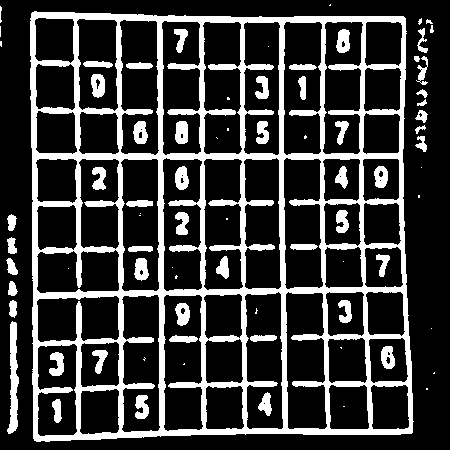

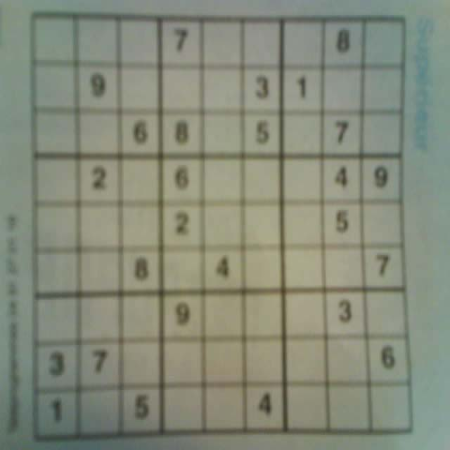

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


image_path = '/root/.cache/kagglehub/datasets/mexwell/sudoku-image-dataset/versions/3/v2_train/v2_train/image1.jpg'
IMAGE_HEIGHT = 450
IMAGE_WIDTH = 450

img = cv2.imread(image_path)
if img is None:
    raise ValueError(f"Failed to load image from {image_path}")

img = cv2.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
imgBlank = np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 3), np.uint8)

imgThreshold = preprocess_sudoku_image(img, blur_type='gaussian',blur_size=5, block_size=13, constant_c=3, show_images=False)

cv2_imshow(imgThreshold)
cv2_imshow(img)


## Step 2: Find Contours

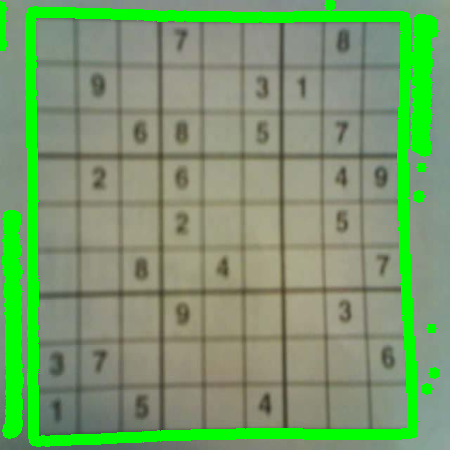

In [ ]:
imgContours = img.copy()
imgBigContour = img.copy()

contours, hierarchy = cv2.findContours(imgThreshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(imgContours, contours, -1, (0, 255, 0), 10)

cv2_imshow(imgContours)

Reordered Points:
 [[ 32.  12.]
 [405.  18.]
 [411. 433.]
 [ 34. 440.]]
Perspective Transform Matrix:
 [[ 1.16742324e+00 -5.45524878e-03 -3.72920807e+01]
 [-1.70648588e-02  1.06086539e+00 -1.21843092e+01]
 [-8.12015874e-05  2.65587977e-05  1.00000000e+00]]


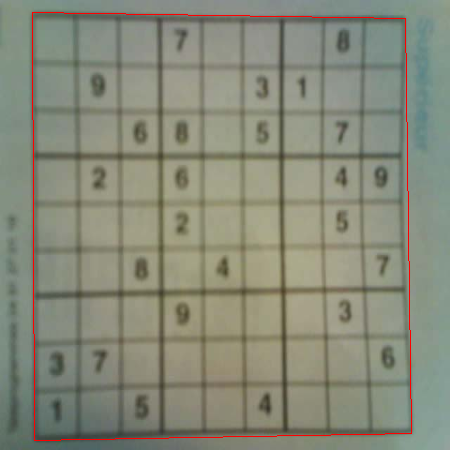

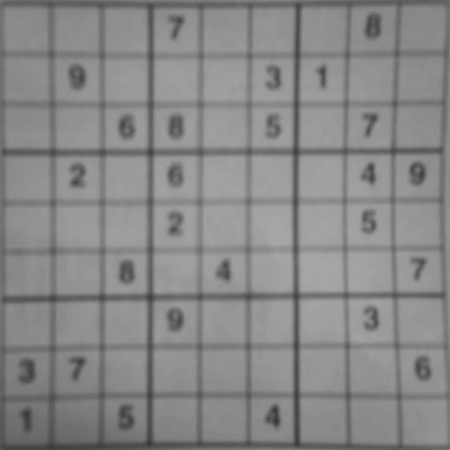

In [ ]:
# Assuming contours have already been calculated
biggest, max_area = biggestContour(contours)
# print("Biggest Contour Points:\n", biggest)

if biggest.size != 0:
    # Reorder points and prepare for perspective transform
    biggest = reorder_points(biggest)
    print("Reordered Points:\n", biggest)

    # Draw the contour on the original image for visualization
    cv2.drawContours(imgBigContour, [biggest.astype(int)], -1, (0, 0, 255),1)

    # Define source points (biggest) and destination points (pts2)
    pts1 = np.float32(biggest)
    pts2 = np.float32([[0, 0], [IMAGE_WIDTH, 0], [IMAGE_WIDTH, IMAGE_HEIGHT], [0, IMAGE_HEIGHT]])

    # Get transformation matrix
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    print("Perspective Transform Matrix:\n", matrix)

    # Perform the perspective warp
    imgWarpColored = cv2.warpPerspective(img, matrix, (IMAGE_WIDTH, IMAGE_HEIGHT))

    #Display the BigContour
    cv2_imshow(imgBigContour)
    imgWarpColored = cv2.cvtColor(imgWarpColored, cv2.COLOR_BGR2GRAY)

    # Display the result
    cv2_imshow(imgWarpColored)
else:
    print("No Sudoku Found")


## Step 3: Detect Digits

In [ ]:
imgSolvedDigits = imgBlank.copy()
boxes = Splitting_Boxes(imgWarpColored)
print(boxes.shape)

# blurred = cv2.GaussianBlur(boxes[7], (5,5), 0)
# cv2_imshow(blurred)
# thresh = cv2.adaptiveThreshold(
#     blurred,
#     255,
#     cv2.ADAPTIVE_THRESH_MEAN_C,
#     cv2.THRESH_BINARY_INV,
#     13,
#     3
# )
# resized_image = cv2.resize(thresh, (28, 28))
# resized_image = cv2.dilate(resized_image, (1,1))
# # resized_image = cv2.erode(resized_image, (1,1))
# cv2_imshow(resized_image)
# plt.imshow(resized_image, cmap=plt.get_cmap('gray'))
# plt.show()

[[122 118 113 ... 105 102 103]
 [115 111 106 ...  99  95  95]
 [111 106 102 ...  92  88  87]
 ...
 [113 112 115 ... 128 121 117]
 [113 112 112 ... 127 120 116]
 [113 111 110 ... 126 119 114]]


In [ ]:
dat_file_path = '/root/.cache/kagglehub/datasets/mexwell/sudoku-image-dataset/versions/3/v2_train/v2_train/image1.dat'  # Replace with your file path
sudoku_grid = extract_digits_from_dat(dat_file_path)
len(sudoku_grid.flatten())


81

In [ ]:
train_folder = "/root/.cache/kagglehub/datasets/mexwell/sudoku-image-dataset/versions/3/v2_train/v2_train"
test_folder = "/root/.cache/kagglehub/datasets/mexwell/sudoku-image-dataset/versions/3/v2_test/v2_test"

extract_digits_from_dat(os.path.join(train_folder, "image1.dat"))

## Step 4: Setting Up The Models For Predictions
- Using MNIST dataset
- Using downlaoded dataset


##### Using MNIST (Not Ideal)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


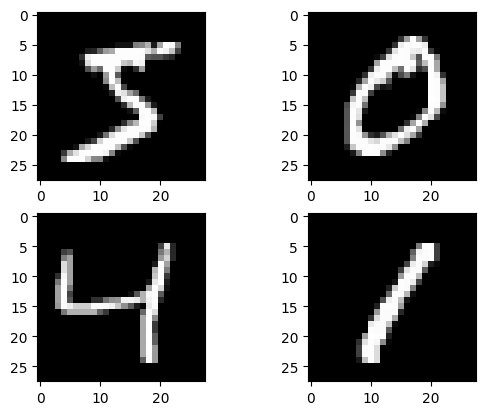

In [ ]:
# Plot ad hoc mnist instances
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
# load (downloaded if needed) the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# plot 4 images as gray scale
plt.subplot(221)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

In [ ]:
# Scale images to the [0, 1] range
x_train = X_train.astype("float32") / 255
x_test = X_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")
print(x_train[0].shape)

x_train shape: (60000, 28, 28, 1)
y_train shape: (60000,)
60000 train samples
10000 test samples
(28, 28, 1)


In [ ]:
# from tensorflow.keras.datasets import mnist
from tensorflow import keras
import numpy as np

num_classes = 10
input_shape = (28, 28, 1)

model = keras.Sequential(
    [
        keras.layers.Input(shape=input_shape),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(num_classes, activation="softmax"),
    ]
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 10, 10, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 260,298 (1016.79 KB)

 Trainable params: 260,298 (1016.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="acc"),
    ],
)

batch_size = 128
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="model_at_epoch_{epoch}.keras"),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),
]

model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.15,
    callbacks=callbacks,
)
score = model.evaluate(x_test, y_test, verbose=0)

Epoch 1/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - acc: 0.5399 - loss: 1.2964 - val_acc: 0.9667 - val_loss: 0.1290
Epoch 2/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - acc: 0.9285 - loss: 0.2401 - val_acc: 0.9769 - val_loss: 0.0882
Epoch 3/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - acc: 0.9512 - loss: 0.1611 - val_acc: 0.9820 - val_loss: 0.0603
Epoch 4/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - acc: 0.9639 - loss: 0.1177 - val_acc: 0.9852 - val_loss: 0.0535
Epoch 5/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - acc: 0.9683 - loss: 0.1037 - val_acc: 0.9858 - val_loss: 0.0473
Epoch 6/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - acc: 0.9740 - loss: 0.0876 - val_acc: 0.9886 - val_loss: 0.0370
Epoch 7/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - acc: 0.9782 - loss: 0.0742 - val_acc: 0.9853 - val_loss: 0.0517
Epoch 8/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - acc: 0.9800 - loss: 0.0687 - val_acc: 0.9899 - val_loss: 0.0378


In [ ]:
model = keras.models.load_model("final_model.keras")

In [ ]:
np.expand_dims(np.array([resized_image]), -1).shape

(1, 28, 28, 1)

In [ ]:
pred = model.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


2


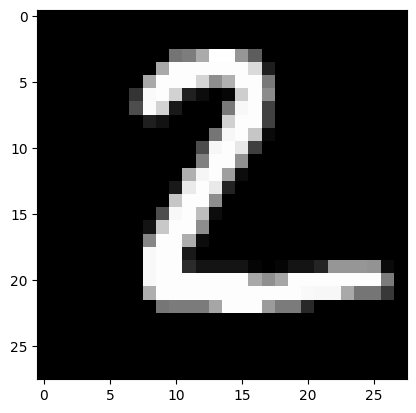

In [ ]:
print(y_test[1])
plt.imshow(x_test[1], cmap=plt.get_cmap('gray'))
plt.show()

##### Using Downloaded Dataset (This Is the Model I am Using)

In [ ]:
# Scale images to the [0, 1] range
x_train = X_train
x_test = X_test
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")
print(x_train[0].shape)

x_train shape: (12474, 50, 50, 1)
y_train shape: (12474,)
y_test shape: (3159, 50, 50, 1)
y_test shape: (3159,)
12474 train samples
3159 test samples
(50, 50, 1)


In [ ]:
# from tensorflow.keras.datasets import mnist
from tensorflow import keras
import numpy as np

num_classes = 10
input_shape = (50, 50, 1)

model = keras.Sequential(
    [
        keras.layers.Input(shape=input_shape),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu",padding='same'),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same'),
        keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu",padding='same'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding='same'),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(num_classes, activation="softmax"),
    ]
)
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)                   │ (None, 50, 50, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 50, 50, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 25, 25, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 25, 25, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 12, 12, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 278,474 (1.06 MB)

 Trainable params: 278,474 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="acc"),
    ],
)

batch_size = 128
epochs = 40

callbacks = [
    # keras.callbacks.ModelCheckpoint(filepath="model_at_epoch_{epoch}.keras"),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),
]

model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.15,
    callbacks=callbacks,
)
score = model.evaluate(x_test, y_test, verbose=0)

Epoch 1/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 14s 102ms/step - acc: 0.6147 - loss: 1.5949 - val_acc: 0.6400 - val_loss: 1.1107
Epoch 2/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - acc: 0.6467 - loss: 1.1335 - val_acc: 0.6421 - val_loss: 0.9509
Epoch 3/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - acc: 0.6536 - loss: 1.0774 - val_acc: 0.6886 - val_loss: 0.8555
Epoch 4/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - acc: 0.6813 - loss: 0.9929 - val_acc: 0.7067 - val_loss: 0.8114
Epoch 5/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - acc: 0.6959 - loss: 0.9369 - val_acc: 0.7537 - val_loss: 0.7877
Epoch 6/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - acc: 0.7217 - loss: 0.8654 - val_acc: 0.7730 - val_loss: 0.7358
Epoch 7/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - acc: 0.7393 - loss: 0.7973 - val_acc: 0.8237 - val_loss: 0.6113
Epoch 8/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - acc: 0.7568 - loss: 0.7297 - val_acc: 0.8301 - val_loss: 0.5774
Epoch 9/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - acc: 0.79

In [ ]:
# model = keras.models.load_model("/content/model_at_epoch_19.keras")
model.save("final_model.keras")

In [ ]:
np.expand_dims(np.array([resized_image]), -1).shape

(1, 28, 28, 1)

In [ ]:
pred = model.predict(x_test)

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


(array([0]),)
0


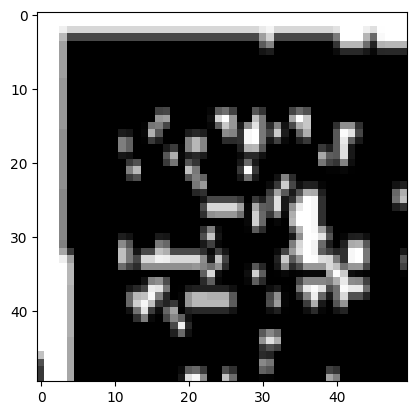

(array([8]),)
8


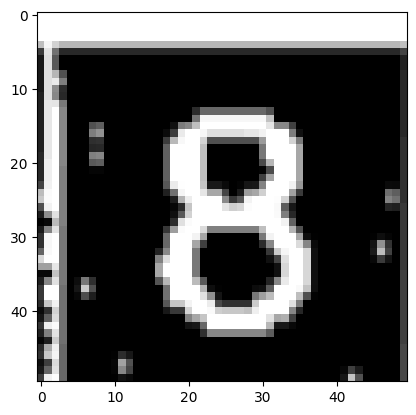

(array([0]),)
0


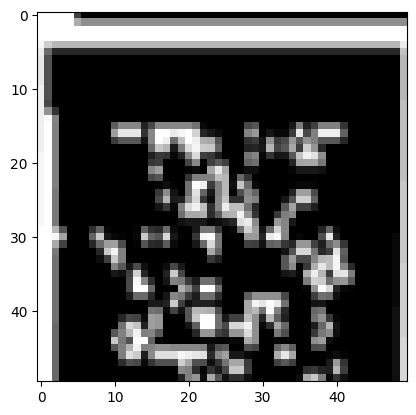

(array([0]),)
0


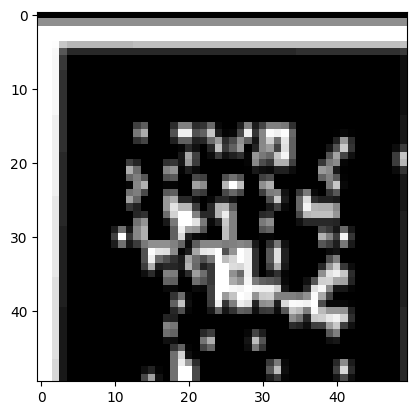

(array([0]),)
0


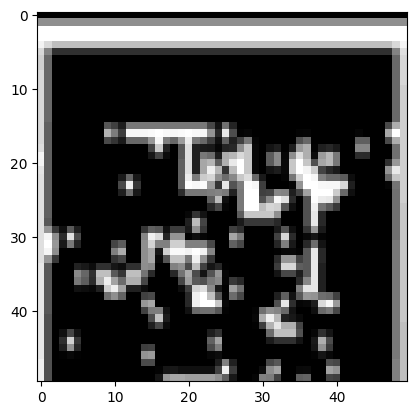

(array([7]),)
7


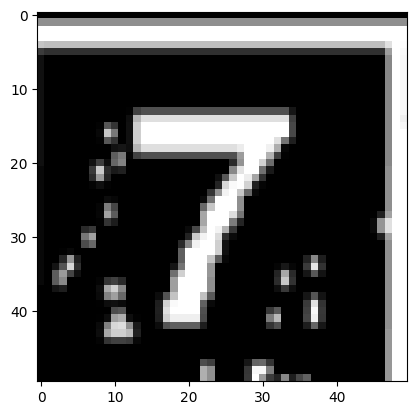

(array([0]),)
0


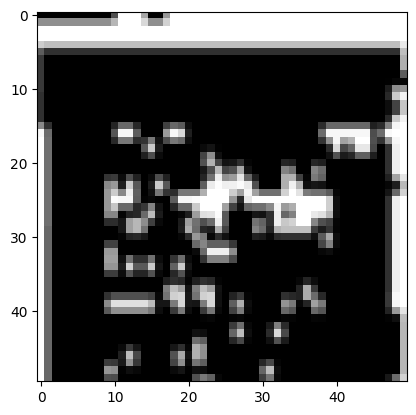

(array([0]),)
0


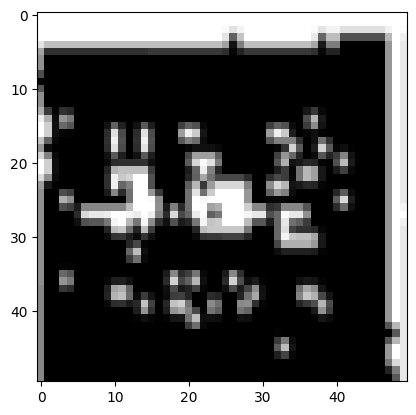

(array([9]),)
9


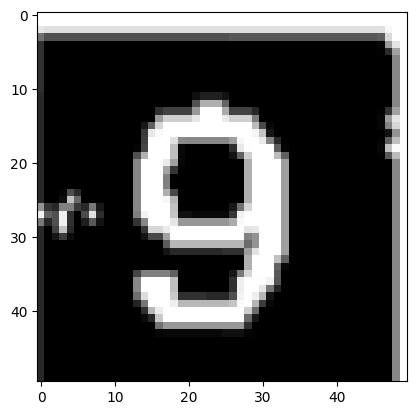

(array([1]),)
1


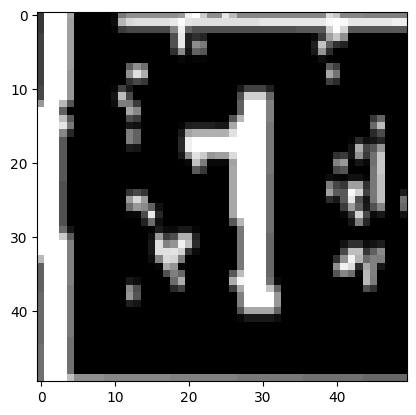

In [ ]:
import matplotlib.pyplot as plt
for i in range(10):
  print(np.where(pred[i] == max(pred[i])))
  print(y_test[i])
  plt.imshow(x_test[i], cmap=plt.get_cmap('gray'))
  plt.show()
# print(pred[1])
# print(y_test[1])
# plt.imshow(x_test[1], cmap=plt.get_cmap('gray'))
# plt.show()

#### Using Pre-trained Model (Did'nt Test It)

In [ ]:
from tensorflow import keras
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model = ResNet50(weights='imagenet')

img_path = 'elephant.jpg'
img = keras.utils.load_img(img_path, target_size=(224, 224))
x = keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])

## Step 5: Making Predictions on images
- Make Predictions
- Show on Image


In [ ]:
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np
# Initialize processor
# processor = SudokuImageProcessor()

model = keras.models.load_model("final_model.keras")

def get_prediction(boxes, model):
  results = []
  # print("Shape of Input Boxes: ",boxes[i].shape)
  for box in boxes:
    box = np.expand_dims(box, axis=0)
    # print(box.shape)
    prediction = model.predict(box,verbose=0)
    classIndex = np.argmax(prediction)
    probabilityValue = np.amax(prediction)
    if probabilityValue > 0.8:
      results.append(classIndex)
    else:
      results.append(0)
  return results

def display_numbers(image, numbers, color=(0, 255, 0)):
  rows = 9
  cols = 9
  cell_width = image.shape[1] // cols
  cell_height = image.shape[0] // rows
  for i in range(rows):
    for j in range(cols):
      x = j * cell_width
      y = i * cell_height
      number = numbers[i * cols + j]
      if number != 0:
        cv2.putText(image, str(number), (x + cell_width // 2, y + cell_height // 2), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)


imgBlank = np.zeros((450, 450, 3), np.uint8)
# predictions = np.asarray(get_prediction(reshaped_cells, model))
pos_array = np.where(predictions > 0,0,1)
# predictions[pos_array] = 1
print(pos_array)
print(predictions)

# print("Blank Canvas")
# cv2_imshow(imgBlank)
# detectedImage = display_numbers(imgBlank, predictions)
# print("Detected Numbers")
# cv2_imshow(imgBlank)

[1 1 1 0 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 1 0 0 1 0 1 0 1 1 0 1 0 1 1 1 0 0 1
 1 1 0 1 1 1 0 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 0 0 1 1 1 1 1 1 0 0 1
 0 1 1 0 1 1 1]
[0 0 0 7 0 0 0 8 0 0 9 0 0 0 3 1 0 0 0 0 6 8 0 5 0 7 0 0 2 0 6 0 0 0 4 9 0
 0 0 2 0 0 0 5 0 0 0 8 0 4 0 0 0 7 0 0 0 9 0 0 0 3 0 3 7 0 0 0 0 0 0 6 1 0
 5 0 0 4 0 0 0]


## Step 6: Solve the Puzzle

In [ ]:
grid = predictions.reshape((9, 9))
solutions_grid = grid.copy()
# predictions_grid[0][7] = 0
print(solutions_grid)

# Usage:
solution_count = 0
solution = solve(solutions_grid)  # Resets count automatically
solution = solution.flatten()
# print(solution)
solution = solution*pos_array
print(solution)

[[0 0 0 7 0 0 0 8 0]
 [0 9 0 0 0 3 1 0 0]
 [0 0 6 8 0 5 0 7 0]
 [0 2 0 6 0 0 0 4 9]
 [0 0 0 2 0 0 0 5 0]
 [0 0 8 0 4 0 0 0 7]
 [0 0 0 9 0 0 0 3 0]
 [3 7 0 0 0 0 0 0 6]
 [1 0 5 0 0 4 0 0 0]]
[2 5 3 0 1 6 9 0 4 8 0 7 4 2 0 0 6 5 4 1 0 0 9 0 2 0 3 7 0 1 0 5 8 3 0 0 9
 6 4 0 3 7 8 0 1 5 3 0 1 0 9 6 2 0 6 4 2 0 7 1 5 0 8 0 0 9 5 8 2 4 1 0 0 8
 0 3 6 0 7 9 2]


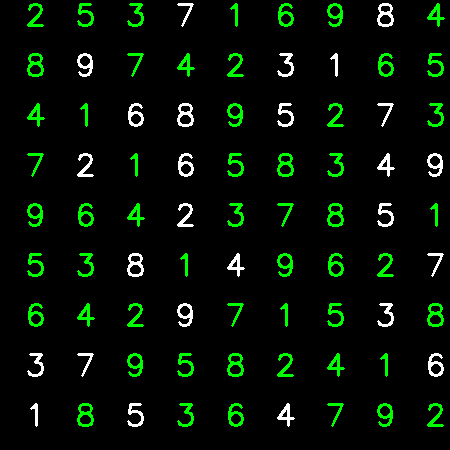

In [ ]:
display_numbers(imgBlank, solution, color=(0, 255, 0))
display_numbers(imgBlank, predictions, color=(255, 255, 255))
cv2_imshow(imgBlank)

In [ ]:
solved_img = processor.reverse_warp_perspective(imgBlank, img)
cv2_imshow(solved_img)

error: OpenCV(4.11.0) /io/opencv/modules/core/src/matmul.dispatch.cpp:550: error: (-215:Assertion failed) scn + 1 == m.cols in function 'perspectiveTransform'


## Testing ***SudokuImagePreprocessor*** Pipeline

SudokuImageProcessor initialized
Starting the image processing pipeline.
Loading image from path: /root/.cache/kagglehub/datasets/mexwell/sudoku-image-dataset/versions/3/v2_train/v2_train/image2.jpg
Loading image from /root/.cache/kagglehub/datasets/mexwell/sudoku-image-dataset/versions/3/v2_train/v2_train/image2.jpg
Image loaded and resized successfully.
Preprocessing image
Image preprocessing completed.
Extracting grid
Sudoku grid successfully extracted and warped.
Splitting grid into individual cells.
Splitting grid into cells
Cell splitting completed.
Running predictions on cell images.
Predicting digits
Predictions completed. Predicted numbers: [9 0 3 0 0 0 0 0 2 0 6 0 4 9 0 1 0 3 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 9 0 0 3
 0 1 0 0 4 0 0 0 0 8 0 7 0 2 4 3 0 1 7 8 5 0 9 3 0 0 0 0 0 0 0 0 7 5 9 0 0
 0 3 6 7 0 0 0]
Converted predicted numbers into 2D grid: [[9, 0, 3, 0, 0, 0, 0, 0, 2], [0, 6, 0, 4, 9, 0, 1, 0, 3], [0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 9, 0, 0], [3, 0, 1, 0, 0, 4

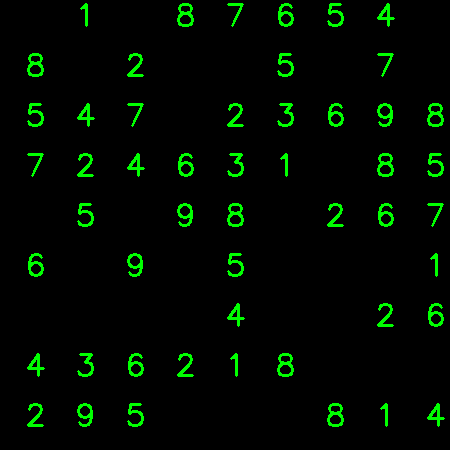

Inverting perspective and overlaying solution


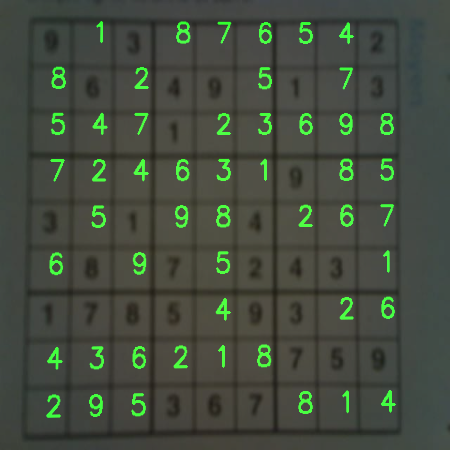

Solution successfully overlayed on the original image.


array([[[68, 74, 66],
        [68, 74, 66],
        [68, 74, 66],
        ...,
        [70, 78, 71],
        [70, 78, 71],
        [70, 78, 71]],

       [[68, 74, 66],
        [68, 74, 66],
        [68, 73, 65],
        ...,
        [70, 78, 71],
        [70, 78, 71],
        [70, 78, 71]],

       [[68, 73, 66],
        [68, 73, 66],
        [68, 72, 66],
        ...,
        [70, 78, 71],
        [70, 78, 71],
        [70, 78, 71]],

       ...,

       [[58, 64, 60],
        [58, 64, 60],
        [57, 64, 60],
        ...,
        [72, 78, 70],
        [72, 78, 70],
        [72, 78, 70]],

       [[58, 64, 61],
        [58, 64, 60],
        [56, 63, 59],
        ...,
        [70, 78, 70],
        [70, 78, 70],
        [70, 78, 70]],

       [[58, 65, 61],
        [57, 64, 60],
        [56, 63, 59],
        ...,
        [70, 78, 70],
        [70, 78, 70],
        [70, 78, 70]]], dtype=uint8)
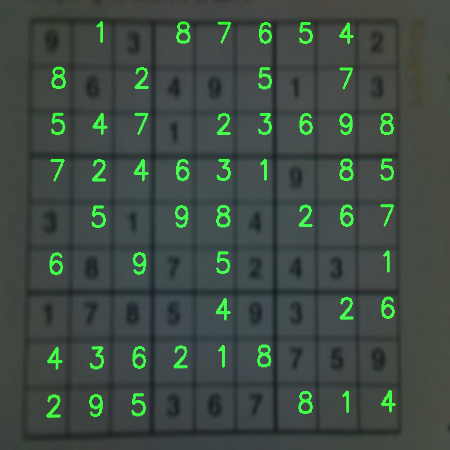

In [ ]:
import matplotlib.pyplot as plt
from tensorflow import keras

# Initialize processor
processor = SudokuImageProcessor()


# 1. Load image
image_path = '/root/.cache/kagglehub/datasets/mexwell/sudoku-image-dataset/versions/3/v2_train/v2_train/image2.jpg'
# ---------------------- Testing the Individual functions ------------------------------- #
# img = processor.load_image(image_path)

# # 2. Preprocess (with step visualization)
# thresh = processor.preprocess_image(img, show_steps=True)

# # 3. Extract grid
# warped_grid, _ = processor.extract_grid(img, thresh)
# if warped_grid is not None:
#   print("warpPerspective Grid Extracted")
#   cv2_imshow(warped_grid)
# else:
#   print("No Sudoku grid found")

# # 4. Split into cells
# cells = np.array(processor.split_into_cells(warped_grid)) #Normalized
# reshaped_cells = np.expand_dims(cells, -1)
# print(reshaped_cells.shape)
# # Display first 9 cells (first row)
# for i in range(9):
#     plt.subplot(1, 9, i+1)
#     plt.imshow(cells[i], cmap='gray')
#     plt.axis('off')

# plt.show()

# ---------------------- Testing the Whole Pipeline ------------------------------- #
model = keras.models.load_model("final_model.keras")
processor.process(image_path,model)

#### extra

In [ ]:
# import cv2
# import numpy as np
# from google.colab.patches import cv2_imshow

# def preprocess_sudoku_image(image, blur_type='gaussian', blur_size=7, block_size=11, constant_c=2):
#     """
#     Pre-Processing Image with adjustable parameters.
#     """
#     # Step 1: Convert to grayscale
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#     # Step 2: Apply chosen blur technique
#     if blur_type == 'gaussian':
#         blurred = cv2.GaussianBlur(gray, (blur_size, blur_size), 0)
#     elif blur_type == 'median':
#         blurred = cv2.medianBlur(gray, blur_size)
#     else:
#         blurred = gray  # No blur if 'none' is chosen

#     # Step 3: Apply Adaptive Threshold
#     thresh = cv2.adaptiveThreshold(
#         blurred,
#         255,
#         cv2.ADAPTIVE_THRESH_MEAN_C,  # You can switch to ADAPTIVE_THRESH_GAUSSIAN_C here
#         cv2.THRESH_BINARY,
#         block_size,
#         constant_c)


#     return thresh


# def evaluate_preprocessing_variations(image):
#     """
#     Evaluate multiple preprocessing parameter combinations and display results.
#     """
#     # Define ranges for parameters to test
#     blur_types = ['gaussian', 'median', 'none']
#     blur_sizes = [5, 7, 9]  # Kernel sizes for blurring
#     block_sizes = [7, 11, 15]  # Sizes for adaptive thresholding
#     constants_c = [1, 2, 3]  # Constant 'C' for fine-tuning

#     # Iterate through combinations of parameters
#     for blur_type in blur_types:
#         for blur_size in blur_sizes:
#             for block_size in block_sizes:
#                 for constant_c in constants_c:
#                     print(f"Testing: blur={blur_type}, kernel={blur_size}, block={block_size}, C={constant_c}")

#                     # Apply preprocessing
#                     processed_image = preprocess_sudoku_image(
#                         image,
#                         blur_type=blur_type,
#                         blur_size=blur_size,
#                         block_size=block_size,
#                         constant_c=constant_c)

#                     # Display the result with cv2_imshow
#                     cv2_imshow(processed_image)


# # Example usage
# image_path = '/root/.cache/kagglehub/datasets/mexwell/sudoku-image-dataset/versions/3/v2_train/v2_train/image1.jpg'
# image = cv2.imread(image_path)

# evaluate_preprocessing_variations(image)


X_train shape: (128, 512, 512, 3)
X_test shape: (32, 512, 512, 3)


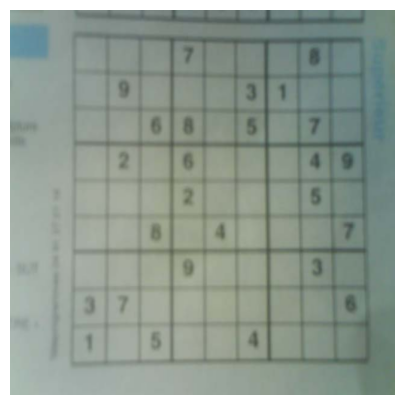

In [ ]:

import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

def load_images_from_folder(folder):

    """Function to load and preprocess images from a folder."""
    images = []  # List to store processed images

    for filename in os.listdir(folder):
        if filename.endswith('.jpg'):  # Ensure we only process .jpg files
            img_path = os.path.join(folder, filename)
            # img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
            image = preprocess_image_pipeline(img_path)
            image = cv2.resize(image, (512, 512))  # Resize to 28x28 pixels
            images.append(image)  # Add the processed image to the list

    return images

# Replace 'path/to/your/images' with the actual path to your image folder
image_folder = '/root/.cache/kagglehub/datasets/mexwell/sudoku-image-dataset/versions/3/v2_train/v2_train'

# Load images and preprocess them
images = load_images_from_folder(image_folder)

# Convert the list of images into a NumPy array
# Reason: NumPy arrays are faster and more efficient for matrix operations during training.
images = np.array(images)

# Split the dataset into training and testing sets
# Reason: Training set is used to teach the model, and testing set evaluates its performance.
X_train, X_test = train_test_split(images, test_size=0.2, random_state=42)

# Display the shapes of the training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Display the first image from the testing set using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))  # Adjust the display size for clarity
plt.imshow(X_test[0], cmap='gray')  # Display the grayscale image
plt.axis('off')  # Hide axes for cleaner visualization
plt.show()


In [ ]:
image1 = X_train[0]
image2 = X_train[1]
image3 = X_test[0]
image4 = X_test[1]

In [ ]:
def preprocess_sudoku_image(image):
    """Improved pipeline to extract Sudoku grid."""
    # Step 1: Load image
    image = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Failed to load image from {image_path}")



    # Step 2: Convert to grayscale and blur
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Step 3: Adaptive thresholding (better for grids)
    thresh = cv2.adaptiveThreshold(
        blurred,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        11,
        2
    )

    # Step 4: Find contours (focus on largest quadrilateral)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)

    # Step 5: Draw the largest contour (for visualization)
    debug_img = img.copy()
    cv2.drawContours(debug_img, [largest_contour], -1, (0, 255, 0), 2)

    return debug_img

# # Example usage:
# image_path = '/root/.cache/kagglehub/datasets/mexwell/sudoku-image-dataset/versions/3/v2_train/v2_train/image1.jpg'
# processed_img = preprocess_sudoku_image(image_path)

# # Display
# plt.figure(figsize=(8, 8))
# plt.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))  # Matplotlib expects RGB
# plt.axis('off')
# plt.show()